# Music genre prediction

## Вводная информация

### Описание задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Этапы работы

* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

### Данные

* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение * 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

### Описание полей данных

* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность 
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - тональность
* liveness - привлекательность
* loudness - громкость
* mode - наклонение
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Предподготовка данных

### Загрузка и изучение данных

In [395]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, accuracy_score, classification_report)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler

from catboost import CatBoostClassifier
from sklearn.utils import resample, shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [396]:
train = pd.read_csv('kaggle_music_genre_train.csv')

In [397]:
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [398]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [399]:
train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

### Работа с пропусками и дибликатами

In [400]:
train = train.dropna(subset=['key'])
train = train.dropna(subset=['mode'])
train = train.dropna(subset=['tempo'])

In [401]:
train['key'] = train['key'].fillna('unknown')
train['mode'] = train['mode'].fillna('unknown')
train['tempo'] = train['tempo'].fillna(0)

In [402]:
print(train.isna().sum())

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64


In [403]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,18754.0,55928.931908,20712.918768,20011.00000,38045.25000,55998.000000,73889.25000,91758.000
acousticness,18754.0,0.275025,0.321970,0.00000,0.01500,0.121000,0.47100,0.996
danceability,18754.0,0.561725,0.171969,0.06000,0.45100,0.570000,0.68200,0.978
duration_ms,18754.0,220725.353631,127306.860752,-1.00000,177517.75000,219709.500000,266506.75000,4497994.000
energy,18754.0,0.625431,0.251477,0.00101,0.47000,0.666000,0.83100,0.999
instrumentalness,18754.0,0.160718,0.307244,0.00000,0.00000,0.000146,0.08570,0.996
liveness,18754.0,0.198873,0.166665,0.01360,0.09740,0.130000,0.25400,1.000
loudness,18754.0,-8.553494,5.505285,-44.40600,-10.25475,-7.044000,-5.05225,3.744
speechiness,18754.0,0.091178,0.097573,0.02230,0.03560,0.048950,0.09490,0.932
tempo,18754.0,120.929143,30.423797,34.76500,95.93725,120.011000,141.94900,220.041


In [404]:
# удалим строки где переменная 'duration_ms' имеет значение 0 и меньше
train = train[train['duration_ms'] > 0]
train = train[train['duration_ms'] < 2_000_000]

In [405]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,16911.0,55959.809177,20707.580002,20011.00000,38076.0000,56032.000000,73916.50000,91758.000
acousticness,16911.0,0.274645,0.321918,0.00000,0.0147,0.121000,0.46900,0.996
danceability,16911.0,0.561370,0.171962,0.06000,0.4510,0.570000,0.68100,0.978
duration_ms,16911.0,244098.290698,98430.581187,15509.00000,192000.0000,227200.000000,272861.50000,1778440.000
energy,16911.0,0.626538,0.251861,0.00101,0.4710,0.668000,0.83300,0.999
instrumentalness,16911.0,0.161844,0.308199,0.00000,0.0000,0.000156,0.08885,0.996
liveness,16911.0,0.199149,0.166920,0.01360,0.0975,0.130000,0.25400,1.000
loudness,16911.0,-8.546572,5.503910,-44.40600,-10.2545,-7.037000,-5.04200,3.744
speechiness,16911.0,0.090976,0.097394,0.02230,0.0356,0.048900,0.09470,0.932
tempo,16911.0,120.827556,30.372265,34.76500,95.9110,120.006000,141.85750,219.331


In [406]:
train = train.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [407]:
# проверим есть ли дубликаты в тренировочном и тестовом датасетах
train.duplicated().sum()

6

In [408]:
train = train.drop_duplicates()

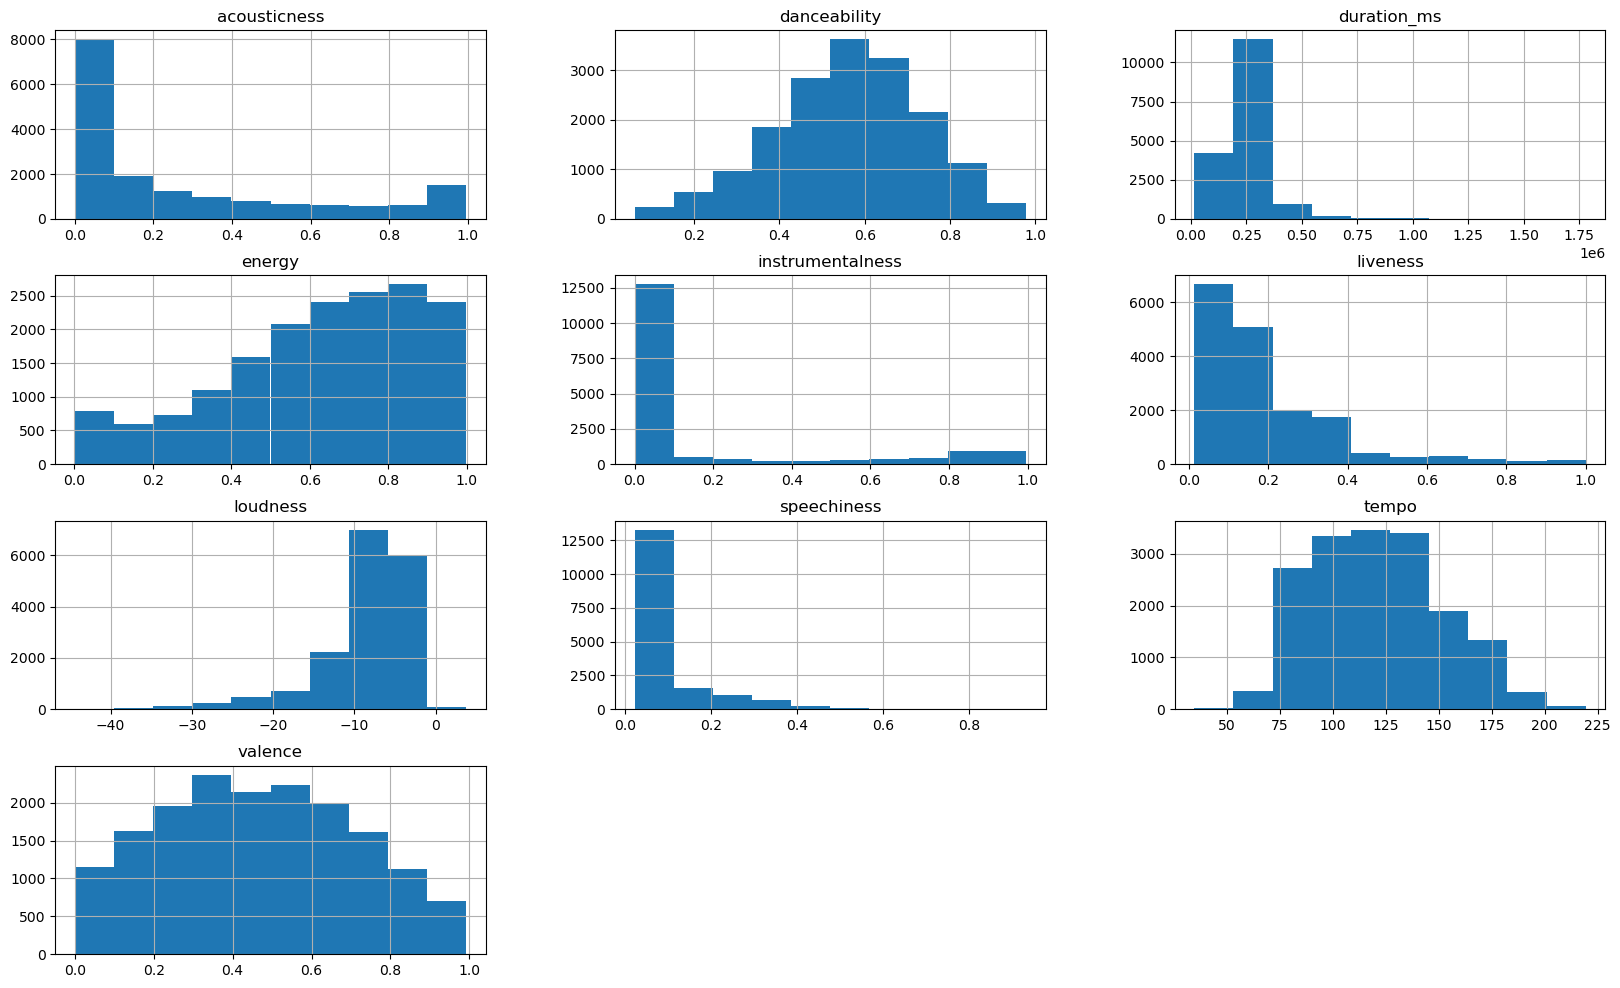

In [409]:
# построим гистограммы распределения тренировочного датасета
train.hist(figsize=(20, 12));

In [410]:
phik_overview = train.phik_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


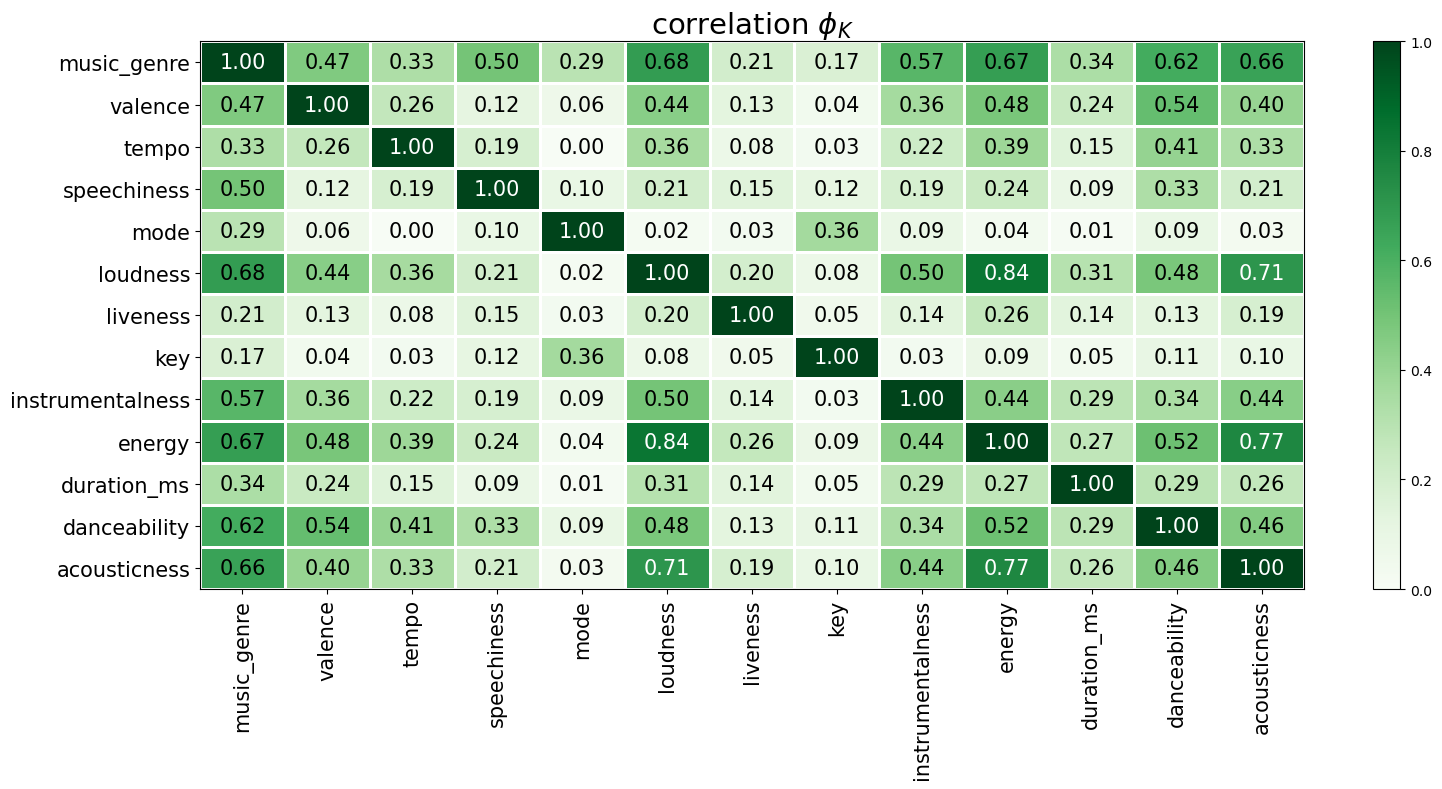

In [411]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

In [412]:
significance_overview = train.significance_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


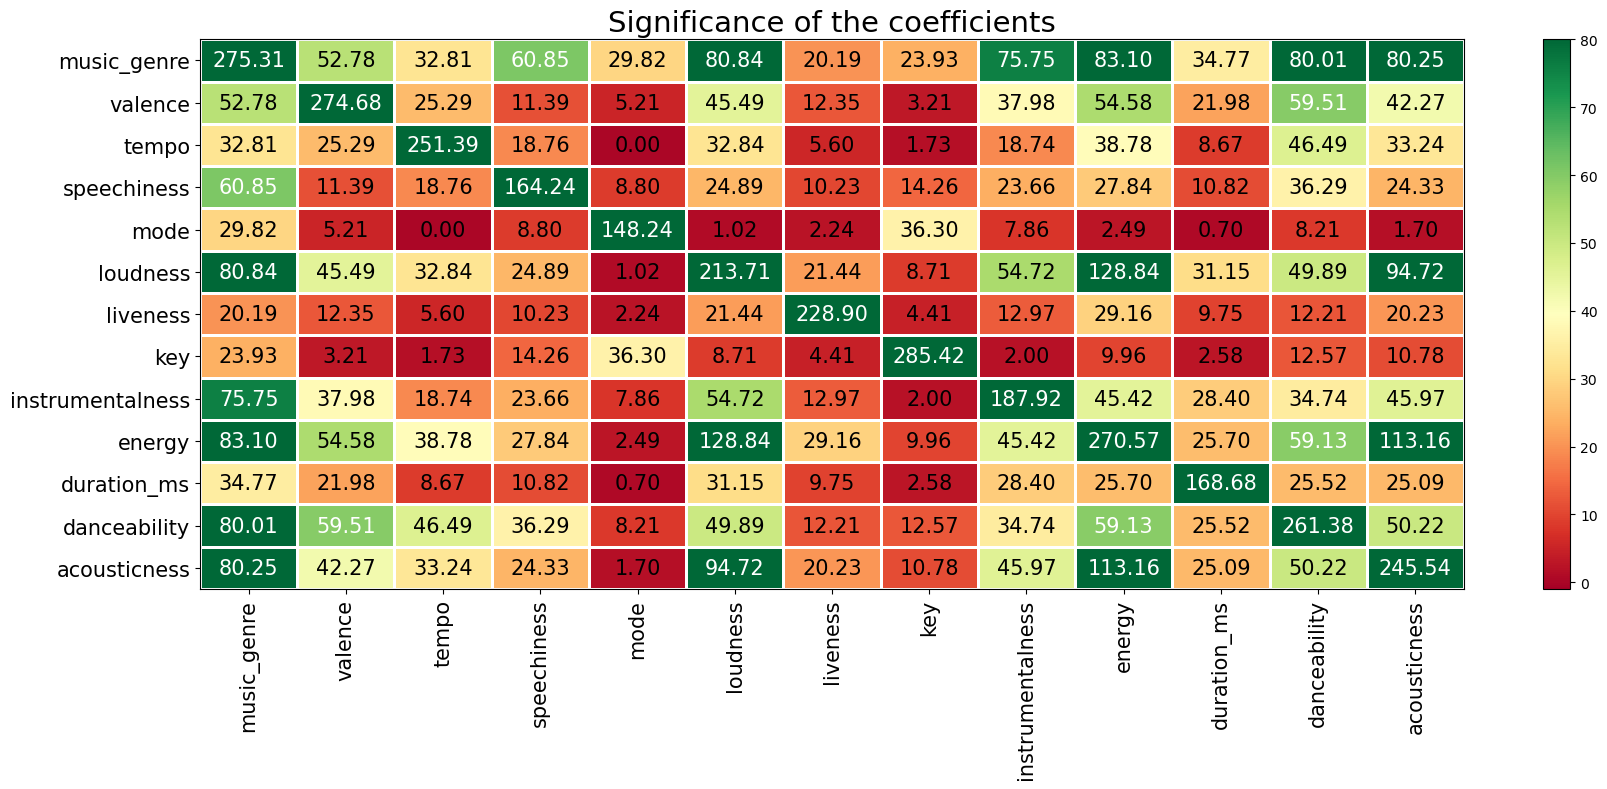

In [413]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-1, vmax=80, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 8))
plt.tight_layout()

In [414]:
global_correlation, global_labels = train.global_phik() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


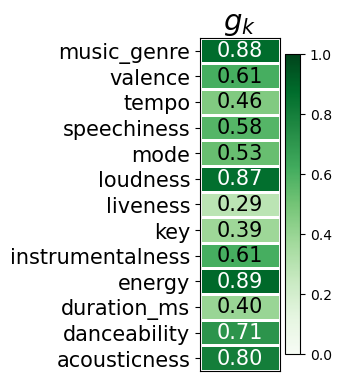

In [415]:
plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

In [416]:
numeric_data = train[['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']]

vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_data.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]

print(vif_data)

            Feature        VIF
0       duration_ms   7.149150
1      acousticness   3.800285
2      danceability  11.783197
3            energy  16.817309
4  instrumentalness   1.788285
5          liveness   2.571854
6          loudness   8.443149
7       speechiness   2.121626
8             tempo  15.101710
9           valence   6.577488


In [417]:
'''train['combined_feature'] = (train['energy'] + train['tempo'] + train['danceability']) / 3
train = train.drop(['energy', 'tempo', 'danceability'], axis=1)'''

"train['combined_feature'] = (train['energy'] + train['tempo'] + train['danceability']) / 3\ntrain = train.drop(['energy', 'tempo', 'danceability'], axis=1)"

In [418]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16905 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      16905 non-null  float64
 1   danceability      16905 non-null  float64
 2   duration_ms       16905 non-null  float64
 3   energy            16905 non-null  float64
 4   instrumentalness  16905 non-null  float64
 5   key               16905 non-null  object 
 6   liveness          16905 non-null  float64
 7   loudness          16905 non-null  float64
 8   mode              16905 non-null  object 
 9   speechiness       16905 non-null  float64
 10  tempo             16905 non-null  float64
 11  valence           16905 non-null  float64
 12  music_genre       16905 non-null  object 
dtypes: float64(10), object(3)
memory usage: 1.8+ MB


In [419]:
train['key'].value_counts() 

G     1980
C     1846
C#    1840
D     1813
A     1723
F     1369
B     1312
E     1304
G#    1086
A#    1071
F#    1025
D#     536
Name: key, dtype: int64

In [420]:
train['mode'].value_counts() 

Major    10882
Minor     6023
Name: mode, dtype: int64

In [421]:
train['music_genre'].value_counts() 

Blues          2392
Alternative    2149
Electronic     2127
Rap            1979
Rock           1779
Country        1745
Anime          1589
Classical      1144
Jazz           1052
Hip-Hop         949
Name: music_genre, dtype: int64

## Подготовка данных к обучению моделей

### Тестируем pipeline

In [422]:
num_cols = ['duration_ms', 'acousticness', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'danceability', 'valence', 'tempo', 'energy']
cat_cols = ['key', 'mode']

In [423]:
X = train[num_cols+cat_cols]
y = train['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [424]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13524, 12), (3381, 12), (13524,), (3381,))

In [425]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale', RobustScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [426]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

In [427]:
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])

In [428]:
set_config(display='diagram')
display(clf_pipeline)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness',
                                                   'danceability', 'valence',
                                                   'tempo', 'energy']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['key', 'mode'])])),
                ('model', LogisticRegression(multi_class='multinomial'))])

In [429]:
param_grid = {
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l2', 'none'] # changed penalty to l2 or none
}

In [430]:
grid_pipeline = GridSearchCV(clf_pipeline, param_grid)

In [431]:
%%time

grid_pipeline.fit(X_train, y_train)

preds = grid_pipeline.predict(X_test)
f1 = f1_score(y_test, preds, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)

/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will 

F1 score: 0.38683493480001274
Best parameters: {'model__C': 0.1, 'model__penalty': 'l2'}
Best score: 0.40350416716796644
CPU times: user 19 s, sys: 3.04 s, total: 22.1 s
Wall time: 12.5 s


/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [432]:
"""%%time

clf = SVC()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__C': [0.1, 1, 10],
'model__kernel': ['linear', 'rbf', 'poly']}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)

# Получение предсказаний на тестовом наборе данных
y_pred = grid_pipeline.predict(X_test)

# Вычисление F1-меры
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")

# Вывод наилучших параметров и оценки
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)"""

'%%time\n\nclf = SVC()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__C\': [0.1, 1, 10],\n\'model__kernel\': [\'linear\', \'rbf\', \'poly\']}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\n\n# Получение предсказаний на тестовом наборе данных\ny_pred = grid_pipeline.predict(X_test)\n\n# Вычисление F1-меры\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\n\n# Вывод наилучших параметров и оценки\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

In [433]:
"""%%time

clf = RandomForestClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__n_estimators': [100, 200, 300],
'model__max_depth': [None, 5, 10]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)"""

'%%time\n\nclf = RandomForestClassifier()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__n_estimators\': [100, 200, 300],\n\'model__max_depth\': [None, 5, 10]}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\ny_pred = grid_pipeline.predict(X_test)\n\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

In [434]:
"""%%time

clf = GradientBoostingClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__n_estimators': [100, 200, 300],
'model__max_depth': [3, 5, 7],
'model__learning_rate': [0.1, 0.01, 0.001]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)"""

'%%time\n\nclf = GradientBoostingClassifier()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__n_estimators\': [100, 200, 300],\n\'model__max_depth\': [3, 5, 7],\n\'model__learning_rate\': [0.1, 0.01, 0.001]}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\ny_pred = grid_pipeline.predict(X_test)\n\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

In [435]:
"""%%time

clf = MLPClassifier()

clf_pipeline = Pipeline(steps=[
('col_trans', col_trans),
('model', clf)
])

parameters = {'model__hidden_layer_sizes': [(100,), (200,), (300,)],
'model__activation': ['relu', 'tanh', 'logistic'],
'model__alpha': [0.0001, 0.001, 0.01]}

grid_pipeline = GridSearchCV(clf_pipeline, parameters)

grid_pipeline.fit(X_train, y_train)
y_pred = grid_pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1 score: {f1}")
print("Best parameters:", grid_pipeline.best_params_)
print("Best score:", grid_pipeline.best_score_)"""

'%%time\n\nclf = MLPClassifier()\n\nclf_pipeline = Pipeline(steps=[\n(\'col_trans\', col_trans),\n(\'model\', clf)\n])\n\nparameters = {\'model__hidden_layer_sizes\': [(100,), (200,), (300,)],\n\'model__activation\': [\'relu\', \'tanh\', \'logistic\'],\n\'model__alpha\': [0.0001, 0.001, 0.01]}\n\ngrid_pipeline = GridSearchCV(clf_pipeline, parameters)\n\ngrid_pipeline.fit(X_train, y_train)\ny_pred = grid_pipeline.predict(X_test)\n\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"F1 score: {f1}")\nprint("Best parameters:", grid_pipeline.best_params_)\nprint("Best score:", grid_pipeline.best_score_)'

### Работаем вручную

In [436]:
ohe_key = pd.get_dummies(train['key'], prefix='key', drop_first=True)
ohe_mode = pd.get_dummies(train['mode'], prefix='mode', drop_first=True)
train = pd.concat([train, ohe_key, ohe_mode], axis=1)
train = train.drop(['key', 'mode'], axis=1)

In [437]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16905 entries, 0 to 20393
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      16905 non-null  float64
 1   danceability      16905 non-null  float64
 2   duration_ms       16905 non-null  float64
 3   energy            16905 non-null  float64
 4   instrumentalness  16905 non-null  float64
 5   liveness          16905 non-null  float64
 6   loudness          16905 non-null  float64
 7   speechiness       16905 non-null  float64
 8   tempo             16905 non-null  float64
 9   valence           16905 non-null  float64
 10  music_genre       16905 non-null  object 
 11  key_A#            16905 non-null  uint8  
 12  key_B             16905 non-null  uint8  
 13  key_C             16905 non-null  uint8  
 14  key_C#            16905 non-null  uint8  
 15  key_D             16905 non-null  uint8  
 16  key_D#            16905 non-null  uint8 

In [438]:
features = train.drop(['music_genre'], axis=1)
target = train['music_genre']

In [439]:
scaler = StandardScaler()
scaler.fit(features)
features = pd.DataFrame(scaler.transform(features), columns=features.columns)

print(features.shape) 

(16905, 22)


In [440]:
'''label_encoder = LabelEncoder()

target = label_encoder.fit_transform(target)'''

'label_encoder = LabelEncoder()\n\ntarget = label_encoder.fit_transform(target)'

In [441]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, stratify=y)

In [442]:
features.head(10)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
0,0.637629,0.631588,-0.624184,-1.093733,-0.468106,-0.503929,-1.506901,-0.458635,-0.640256,-0.064197,...,-0.350121,-0.349482,2.885191,-0.180955,-0.289110,-0.296847,-0.25406,-0.36423,-0.262015,-0.743964
1,-0.098543,-0.636107,-0.578674,0.172788,-0.525040,-0.545865,0.028271,-0.572624,-0.255481,0.301263,...,-0.350121,-0.349482,-0.346598,-0.180955,-0.289110,-0.296847,-0.25406,-0.36423,-0.262015,1.344151
2,-0.145136,-0.624477,-0.717692,0.704806,-0.525205,-0.108537,0.603643,2.875810,-1.312026,-0.499465,...,-0.350121,-0.349482,-0.346598,-0.180955,3.458895,-0.296847,-0.25406,-0.36423,-0.262015,1.344151
3,-0.680026,1.660864,0.120776,0.978756,-0.525195,0.754136,0.679947,-0.108451,-0.158818,2.054652,...,-0.350121,-0.349482,-0.346598,-0.180955,-0.289110,-0.296847,-0.25406,-0.36423,3.816582,1.344151
4,-0.148242,1.050276,-0.495375,-0.204389,-0.525199,-0.138491,0.544598,-0.433988,-1.459720,0.481940,...,2.856158,-0.349482,-0.346598,-0.180955,-0.289110,-0.296847,-0.25406,-0.36423,-0.262015,-0.743964
5,-0.536519,-1.473484,1.511527,-0.144835,0.678428,-0.521902,-0.573262,-0.579813,0.820687,0.124692,...,-0.350121,-0.349482,2.885191,-0.180955,-0.289110,-0.296847,-0.25406,-0.36423,-0.262015,-0.743964
6,-0.852626,0.544361,-0.262401,0.240283,-0.525128,-0.672270,-0.588886,-0.588028,0.101804,-0.224343,...,-0.350121,-0.349482,-0.346598,-0.180955,-0.289110,-0.296847,-0.25406,-0.36423,-0.262015,1.344151
7,2.106867,0.172194,0.667564,-2.054542,0.633008,-0.641118,-1.712741,-0.473012,0.321535,-0.290044,...,-0.350121,-0.349482,-0.346598,5.526226,-0.289110,-0.296847,-0.25406,-0.36423,-0.262015,-0.743964
8,-0.247641,0.497840,0.398975,-0.124983,-0.524822,-0.420058,0.023911,-0.589055,-1.559017,0.330007,...,-0.350121,-0.349482,-0.346598,-0.180955,-0.289110,-0.296847,-0.25406,-0.36423,-0.262015,1.344151
9,-0.753022,-0.141822,-0.072103,1.332111,0.100943,-0.246325,1.053475,0.308483,1.290602,-0.146323,...,2.856158,-0.349482,-0.346598,-0.180955,-0.289110,-0.296847,-0.25406,-0.36423,-0.262015,-0.743964


In [443]:
target.head()

0        Country
1           Rock
2    Alternative
3        Hip-Hop
4    Alternative
Name: music_genre, dtype: object

In [444]:
'''X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

model = CatBoostClassifier()

param_grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(param_grid,
                                       X=X_train,
                                       y=y_train,
                                       plot=True)'''

"X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)\n\nmodel = CatBoostClassifier()\n\nparam_grid = {'learning_rate': [0.03, 0.1],\n        'depth': [4, 6, 10],\n        'l2_leaf_reg': [1, 3, 5, 7, 9]}\n\ngrid_search_result = model.grid_search(param_grid,\n                                       X=X_train,\n                                       y=y_train,\n                                       plot=True)"

In [445]:
# узнаем количество каждого элемента в target
unique, counts = np.unique(target, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Alternative' 2149]
 ['Anime' 1589]
 ['Blues' 2392]
 ['Classical' 1144]
 ['Country' 1745]
 ['Electronic' 2127]
 ['Hip-Hop' 949]
 ['Jazz' 1052]
 ['Rap' 1979]
 ['Rock' 1779]]


In [446]:
class_weights = {0: 1 / 2149, 1: 1 / 1589, 2: 1 / 2392, 3: 1 / 1144, 4: 1 / 1745, 
                 5: 1 / 2127, 6: 1 / 949, 7: 1 / 1052, 8: 1 / 1979, 9: 1 / 1779}

In [447]:
model = CatBoostClassifier(depth=4, l2_leaf_reg=3, learning_rate=0.1)
model.fit(features_train, target_train)
y_pred = model.predict(features_test)

0:	learn: 2.2009012	total: 26.6ms	remaining: 26.6s
1:	learn: 2.1263481	total: 34.1ms	remaining: 17s
2:	learn: 2.0723259	total: 43.2ms	remaining: 14.4s
3:	learn: 2.0306849	total: 51ms	remaining: 12.7s
4:	learn: 1.9864821	total: 59.5ms	remaining: 11.8s
5:	learn: 1.9515244	total: 67.1ms	remaining: 11.1s
6:	learn: 1.9207506	total: 75.3ms	remaining: 10.7s
7:	learn: 1.8978231	total: 83.5ms	remaining: 10.3s
8:	learn: 1.8744203	total: 95.3ms	remaining: 10.5s
9:	learn: 1.8485052	total: 105ms	remaining: 10.4s
10:	learn: 1.8229237	total: 113ms	remaining: 10.1s
11:	learn: 1.8034664	total: 121ms	remaining: 9.98s
12:	learn: 1.7833739	total: 129ms	remaining: 9.78s
13:	learn: 1.7646307	total: 137ms	remaining: 9.66s
14:	learn: 1.7491446	total: 144ms	remaining: 9.47s
15:	learn: 1.7337835	total: 151ms	remaining: 9.3s
16:	learn: 1.7200757	total: 159ms	remaining: 9.21s
17:	learn: 1.7051571	total: 167ms	remaining: 9.11s
18:	learn: 1.6945252	total: 175ms	remaining: 9.04s
19:	learn: 1.6827086	total: 182ms	rem

In [448]:
f1 = f1_score(target_test, y_pred, average='weighted')
accuracy = accuracy_score(target_test, y_pred)
recall = recall_score(target_test, y_pred, average='weighted')
macro = f1_score(target_test, y_pred, average='macro')
w = f1_score(target_test, y_pred, average='weighted')
micro = f1_score(target_test, y_pred, average='micro')
none = f1_score(target_test, y_pred, average=None)
print('f1 =', f1, 'accuracy =', accuracy, 'recall =', recall, 'macro =', macro, 'w =', w, 'micro =', micro, 'none =', none)

f1 = 0.44353693295323304 accuracy = 0.4655427388346643 recall = 0.4655427388346643 macro = 0.43266983033787715 w = 0.44353693295323304 micro = 0.4655427388346643 none = [0.31273644 0.5184     0.48860529 0.79245283 0.46983312 0.62053571
 0.10980392 0.3197832  0.55674518 0.13780261]


In [458]:
test = pd.read_csv('kaggle_music_genre_test.csv')

In [459]:
tes1 = test

In [460]:
test = test.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [461]:
test['key'] = test['key'].fillna('unknown')
test['mode'] = test['mode'].fillna('unknown')
test['mode'] = test['mode'].fillna(0)

In [462]:
ohe_key = pd.get_dummies(test['key'], prefix='key', drop_first=True)
ohe_mode = pd.get_dummies(test['mode'], prefix='mode', drop_first=True)
test = pd.concat([test, ohe_key, ohe_mode], axis=1)
test = test.drop(['key', 'mode'], axis=1)

In [463]:
test.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_unknown,mode_Minor,mode_unknown
0,0.301000,0.757,146213.0,0.679,0.00000,0.3030,-7.136,0.3560,90.361,0.895,...,0,0,0,0,0,0,0,0,1,0
1,0.538000,0.256,240360.0,0.523,0.00832,0.0849,-5.175,0.0294,78.385,0.318,...,0,0,0,0,0,0,1,0,0,0
2,0.005830,0.678,284000.0,0.770,0.00000,0.1090,-4.399,0.2220,90.000,0.412,...,0,0,0,0,0,0,0,0,1,0
3,0.020300,0.592,177354.0,0.749,0.00000,0.1220,-4.604,0.0483,160.046,0.614,...,0,0,0,0,0,0,0,0,0,0
4,0.000335,0.421,-1.0,0.447,0.01480,0.0374,-8.833,0.2020,73.830,0.121,...,1,0,0,0,0,0,0,0,0,0


In [464]:
y_pred = model.predict(test)

In [470]:
y_pred = y_pred.ravel().tolist()
# Создание столбца с предсказаниями
y_pred_series = pd.Series(y_pred, name='music_genre')

# Создание столбца с instance_id
instance_id_column = tes1['instance_id']

# Создание DataFrame из столбцов
submit = pd.concat([instance_id_column, y_pred_series], axis=1)

# Сохранение DataFrame с предсказаниями в файл
submit.to_csv('submit.csv', index=False)